
### Dataset

In this notebook, we are building a Two-Tower model for Item Retrieval task using synthetic datasets that are mimicking the real [Ali-CCP: Alibaba Click and Conversion Prediction](https://tianchi.aliyun.com/dataset/dataDetail?dataId=408#1) dataset.
### Learning objectives
- Preparing the data with NVTabular
- Training and evaluating Two-Tower model with Merlin Models
- Exporting the model for deployment
- Generating the top K recommendations from the trained model

## Environment Setup

In [1]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
%cd rapidsai-csp-utils
!git checkout 22.12-patch
%cd ..
!python rapidsai-csp-utils/colab/env-check.py
!python rapidsai-csp-utils/colab/pip-install.py

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
/content/rapidsai-csp-utils
Already on '22.12-patch'
Your branch is up to date with 'origin/22.12-patch'.
/content
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************

***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py): started
  error: subprocess-exited-with-error

  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.

  note: This error originates from a subprocess, and is likel

In [2]:
# Install the Merlin Framework
!pip install -U git+https://github.com/NVIDIA-Merlin/models.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/nvtabular.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/core.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/system.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/dataloader.git@release-23.04
!pip install -U git+https://github.com/NVIDIA-Merlin/Transformers4Rec.git@release-23.04
!pip install -U xgboost lightfm implicit

  Cloning https://github.com/NVIDIA-Merlin/models.git (to revision release-23.04) to /tmp/pip-req-build-p8n_poi5
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/models.git /tmp/pip-req-build-p8n_poi5
  Running command git checkout -b release-23.04 --track origin/release-23.04
  Switched to a new branch 'release-23.04'
  Branch 'release-23.04' set up to track remote branch 'release-23.04' from 'origin'.
  Resolved https://github.com/NVIDIA-Merlin/models.git to commit 56c7d6a4b2ec003472bdd176e972125632d070de
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/NVIDIA-Merlin/nvtabular.git (to revision release-23.04) to /tmp/pip-req-build-1bgq__xy
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA-Merlin/nvtabular.git /tmp/pip-req-build-1bgq__xy
  Running command git checkout -b release-23.04 --track origin/rele

## Prepare the Dataset
Reference
- https://github.com/NVIDIA-Merlin/Merlin/blob/main/examples/getting-started-movielens/01-Download-Convert.ipynb


In [3]:
import os

from merlin.core.utils import download_file

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()
import numpy as np

In [4]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("./contents/movielens/data/")
)

In [5]:
download_file(
    "http://files.grouplens.org/datasets/movielens/ml-100k.zip",
    os.path.join(DATA_DIR, "ml-100k.zip"),
)

downloading ml-100k.zip: 4.94MB [00:01, 3.01MB/s]                            
unzipping files: 100%|██████████| 24/24 [00:00<00:00, 225.30files/s]


In [6]:
data_path = DATA_DIR + 'ml-100k/'

# Load user ratings data
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_data = pd.read_csv(data_path + 'u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Load movie information data
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'action',
               'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy',
               'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']
movies_data = pd.read_csv(data_path + 'u.item', sep='|', names=movies_cols, encoding='latin-1')

# Load user information data
users_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_data = pd.read_csv(data_path + 'u.user', sep='|', names=users_cols, encoding='latin-1')

# Step 3: Merge DataFrames
# Merge user ratings with movie information
merged_data = pd.merge(ratings_data, movies_data, on='movie_id')

# Merge the above DataFrame with user information
merged_data = pd.merge(merged_data, users_data, on='user_id')

# Combine the individual genre columns into a single categorical column
genre_cols = ['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama',
              'fantasy', 'film_noir', 'horror', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']

# Create a new column 'genres' by concatenating the genre names if the value is 1
merged_data['genres'] = merged_data[genre_cols].apply(lambda row: '|'.join([col for col in genre_cols if row[col] == 1]), axis=1)

# Drop the individual genre columns + `unknown` + `video_release_date` + `imdb_url`
merged_data.drop(columns=genre_cols + ['unknown', 'video_release_date', 'imdb_url'], inplace=True)

# convert genres to a list
merged_data["genres"] = merged_data["genres"].str.split("|")

# Step 4: Save as parquet
merged_data.to_parquet(f'{DATA_DIR}/movielens_100k.parquet', index=False)

print("Conversion to parquet completed successfully.")

Conversion to parquet completed successfully.


In [7]:
merged_data

,user_id,movie_id,rating,timestamp,title,release_date,age,gender,occupation,zip_code,genres
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,49,M,writer,55105,[comedy]
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,49,M,writer,55105,"[action, adventure, comedy, sci_fi]"
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,49,M,writer,55105,"[comedy, romance]"
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,49,M,writer,55105,[comedy]
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,49,M,writer,55105,"[comedy, drama]"
...,...,...,...,...,...,...,...,...,...,...,...
99995,873,313,5,891392177,Titanic (1997),01-Jan-1997,48,F,administrator,33763,"[action, drama, romance]"
99996,873,326,4,891392656,G.I. Jane (1997),01-Jan-1997,48,F,administrator,33763,"[action, drama, war]"
99997,873,348,3,891392577,Desperate Measures (1998),30-Jan-1998,48,F,administrator,33763,"[crime, drama, thriller]"
99998,873,358,2,891392698,Spawn (1997),01-Aug-1997,48,F,administrator,33763,"[action, adventure, sci_fi, thriller]"


## ETL
Reference
- https://github.com/NVIDIA-Merlin/Merlin/blob/main/examples/getting-started-movielens/02-ETL-with-NVTabular.ipynb

In [8]:
import os
import shutil
import numpy as np
from nvtabular.ops import *
from merlin.schema.tags import Tags

import nvtabular as nvt

from os import path

# Get dataframe library - cudf or pandas
from merlin.core.dispatch import get_lib
pd = get_lib()

/usr/local/lib/python3.10/dist-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


In [9]:
DATA_DIR = os.environ.get(
    "DATA_DIR", os.path.expanduser("./contents/movielens/data/")
)

In [10]:
movies = pd.read_parquet(os.path.join(DATA_DIR, "movielens_100k.parquet"))
movies.head()

,user_id,movie_id,rating,timestamp,title,release_date,age,gender,occupation,zip_code,genres
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,49,M,writer,55105,[comedy]
1,196,257,2,881251577,Men in Black (1997),04-Jul-1997,49,M,writer,55105,"[action, adventure, comedy, sci_fi]"
2,196,111,4,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,49,M,writer,55105,"[comedy, romance]"
3,196,25,4,881251955,"Birdcage, The (1996)",08-Mar-1996,49,M,writer,55105,[comedy]
4,196,382,4,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,49,M,writer,55105,"[comedy, drama]"


In [11]:
# split train, val, test - 80,10,10
sorted_movies = movies.sort_values(by="timestamp")
test_size = int(len(movies) * 0.1)

# selective columns
cols = ['user_id', 'movie_id', 'rating',] #'title', 'gender', 'occupation']
sorted_movies = sorted_movies[cols]

train = sorted_movies[:-test_size * 2].sample(frac=1).reset_index(drop=True)
val = sorted_movies[test_size * 2: -test_size].sample(frac=1).reset_index(drop=True)
test = sorted_movies[-test_size: ].sample(frac=1).reset_index(drop=True)

train.to_parquet(os.path.join(DATA_DIR, "train.parquet"))
val.to_parquet(os.path.join(DATA_DIR, "validation.parquet"))
test.to_parquet(os.path.join(DATA_DIR, "test.parquet"))

In [12]:
train.head()

,user_id,movie_id,rating
0,943,402,2
1,122,661,4
2,943,151,4
3,85,629,3
4,357,831,3


In [13]:
genres = movies[['movie_id','genres']]

In [14]:
# TODO title?
CATEGORICAL_COLUMNS = ["user_id", "movie_id", ]#"gender", "occupation"]
LABEL_COLUMNS = ["rating"]

In [15]:
userId = ["user_id"] >> TagAsUserID()
movieId = ["movie_id"] >> TagAsItemID()

joined = userId + movieId >> JoinExternal(genres, on=["movie_id"])
# joined.graph

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [16]:
# we will add Categorify for our categorical features
cat_features =  joined >> Categorify()

In [17]:
# The ratings are on a scale between 1-5. We want to predict a binary target with 1 for ratings >3 and 0 for ratings <=3
ratings = nvt.ColumnGroup(LABEL_COLUMNS) >> LambdaOp(lambda col: (col > 3).astype("int8")) >> AddTags(Tags.TARGET)

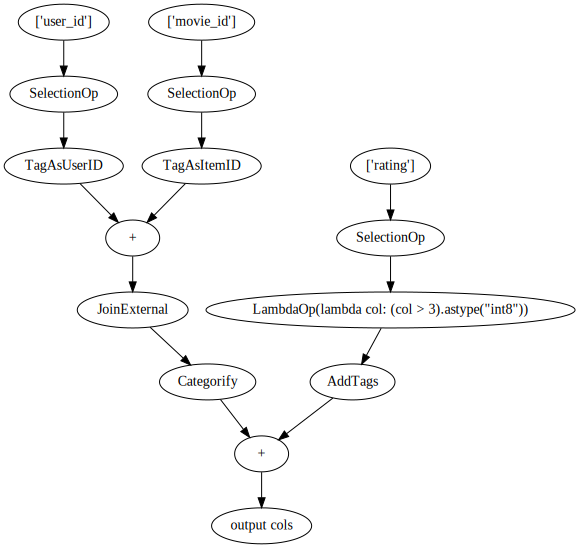

In [18]:
output = cat_features + ratings
(output).graph

In [19]:
workflow = nvt.Workflow(output)

In [20]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [21]:
train_dataset = nvt.Dataset([os.path.join(DATA_DIR, "train.parquet")])
val_dataset = nvt.Dataset([os.path.join(DATA_DIR, "validation.parquet")])
test_dataset = nvt.Dataset([os.path.join(DATA_DIR, "test.parquet")])

/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [22]:
%%time
workflow.fit(train_dataset)

/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.USER: 'user'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.ITEM_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.ITEM: 'item'>, <Tags.ID: 'id'>].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:438: UserWarning: Changing an NVTabular Dataset to CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/merlin/schema/tags.py:149: UserWarning: Compound tags like Tags.USER_ID have been deprecated and will be removed in a future version. Please use the atomic versions of these tags, like [<Tags.US

CPU times: user 1min 34s, sys: 10.8 s, total: 1min 45s
Wall time: 1min 46s


In [23]:
# Make sure we have a clean output path
if path.exists(os.path.join(DATA_DIR, "pp_train")):
    shutil.rmtree(os.path.join(DATA_DIR, "pp_train"))
if path.exists(os.path.join(DATA_DIR, "pp_valid")):
    shutil.rmtree(os.path.join(DATA_DIR, "pp_valid"))
if path.exists(os.path.join(DATA_DIR, "pp_test")):
    shutil.rmtree(os.path.join(DATA_DIR, "pp_test"))

In [24]:
%%time
workflow.transform(train_dataset).to_parquet(
    output_path=os.path.join(DATA_DIR, "train"),
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes
)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.53 µs


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [25]:
%%time
workflow.transform(val_dataset).to_parquet(
    output_path=os.path.join(DATA_DIR, "valid"),
    shuffle=False,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes,
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [26]:
%%time
workflow.transform(test_dataset).to_parquet(
    output_path=os.path.join(DATA_DIR, "test"),
    shuffle=False,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    dtypes=dict_dtypes,
)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


/usr/local/lib/python3.10/dist-packages/merlin/io/dataset.py:264: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


In [27]:
workflow.save(os.path.join(DATA_DIR, "workflow"))
workflow.output_schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.start_index,properties.cat_path,properties.domain.min,properties.domain.max,properties.domain.name,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.value_count.min,properties.value_count.max
0,user_id,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,.//categories/unique.user_id.parquet,0.0,751.0,user_id,752.0,65.0,NaN,NaN
1,movie_id,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,0.0,.//categories/unique.movie_id.parquet,0.0,1616.0,movie_id,1617.0,100.0,NaN,NaN
2,genres,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",True,True,NaN,0.0,0.0,0.0,.//categories/unique.genres.parquet,0.0,19.0,genres,20.0,16.0,0.0,NaN
3,rating,(Tags.TARGET),"DType(name='int8', element_type=<ElementType.I...",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sanity Check

In [28]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "valid", "*.parquet")))
TEST_PATHS = sorted(glob.glob(os.path.join(DATA_DIR, "test", "*.parquet")))
TRAIN_PATHS, VALID_PATHS, TEST_PATHS

(['./contents/movielens/data/train/part_0.parquet'],
 ['./contents/movielens/data/valid/part_0.parquet'],
 ['./contents/movielens/data/test/part_0.parquet'])

In [ ]:
df = pd.read_parquet(TRAIN_PATHS[0])
df.head()

In [30]:
df = pd.read_parquet(VALID_PATHS[0])
df.head()

,user_id,movie_id,genres,rating
0,132,398,"[3, 1, 5]",1.0
1,132,398,"[3, 1, 5]",0.0
2,132,398,"[3, 1, 5]",0.0
3,132,398,"[3, 1, 5]",0.0
4,132,398,"[3, 1, 5]",1.0


In [37]:
df = pd.read_parquet(TEST_PATHS[0])
df.head()

,user_id,movie_id,genres,rating
0,0,376,"[1, 5]",1.0
1,0,376,"[1, 5]",1.0
2,0,376,"[1, 5]",1.0
3,0,376,"[1, 5]",0.0
4,0,376,"[1, 5]",1.0


In [33]:
df = train_dataset.to_ddf().compute()

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   80000 non-null  int64
 1   movie_id  80000 non-null  int64
 2   rating    80000 non-null  int64
dtypes: int64(3)
memory usage: 1.8 MB


In [38]:
del(df)

In [39]:
del(movies)

In [40]:
del(sorted_movies)